In [1]:
# import necessary libraries
import os
import pandas as pd

In [44]:
def preprocess_pr_ghi_data(base_path):
    """
    Processes PR and GHI data and returns exactly 982 combined records.
    Now properly handles multiple measurements per date.
    """
    # Initialize dictionaries to store lists of values per date
    pr_data = {}
    ghi_data = {}
    
    # Process PR data
    print("Processing PR data...")
    pr_path = os.path.join(base_path, 'PR')
    for root, dirs, files in os.walk(pr_path):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                date = file.replace('.csv', '')
                try:
                    df = pd.read_csv(file_path)
                    pr_data[date] = df.iloc[:, 1].tolist()  # Get all PR values for this date
                except Exception as e:
                    print(f"Error reading PR file {file_path}: {e}")
    
    # Process GHI data
    print("\nProcessing GHI data...")
    ghi_path = os.path.join(base_path, 'GHI')
    for root, dirs, files in os.walk(ghi_path):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                date = file.replace('.csv', '')
                try:
                    df = pd.read_csv(file_path)
                    ghi_data[date] = df.iloc[:, 1].tolist()  # Get all GHI values for this date
                except Exception as e:
                    print(f"Error reading GHI file {file_path}: {e}")
    
    # Combine data - assumes same number of measurements per date
    combined_data = []
    for date in sorted(pr_data.keys()):
        if date in ghi_data:
            # Pair corresponding measurements (assuming same count for PR and GHI)
            measurements = min(len(pr_data[date]), len(ghi_data[date]))
            for i in range(measurements):
                combined_data.append({
                    'Date': pd.to_datetime(date),
                    'PR': pr_data[date][i],
                    'GHI': ghi_data[date][i]
                })
    
    # Create DataFrame
    df = pd.DataFrame(combined_data)
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Verify we have exactly 982 rows
    if len(df) != 982:
        print(f"Warning: Expected 982 rows but got {len(df)}. Some data may be missing.")
    
    return df

In [45]:
df_combined = preprocess_pr_ghi_data('dataset')
df_combined.to_csv('combined_pr_ghi.csv', index=False)
print(f"Saved {len(df_combined)} rows to combined_pr_ghi.csv")


Processing PR data...

Processing GHI data...
Saved 982 rows to combined_pr_ghi.csv


In [46]:
df = pd.read_csv('combined_pr_ghi.csv')
df.head()

,Date,PR,GHI
0,2019-07-01,69.575676,3.256608
1,2019-07-01,79.314411,3.976767
2,2019-07-01,61.020006,2.811867
3,2019-07-01,83.262576,3.658408
4,2019-07-01,82.124440,5.590683


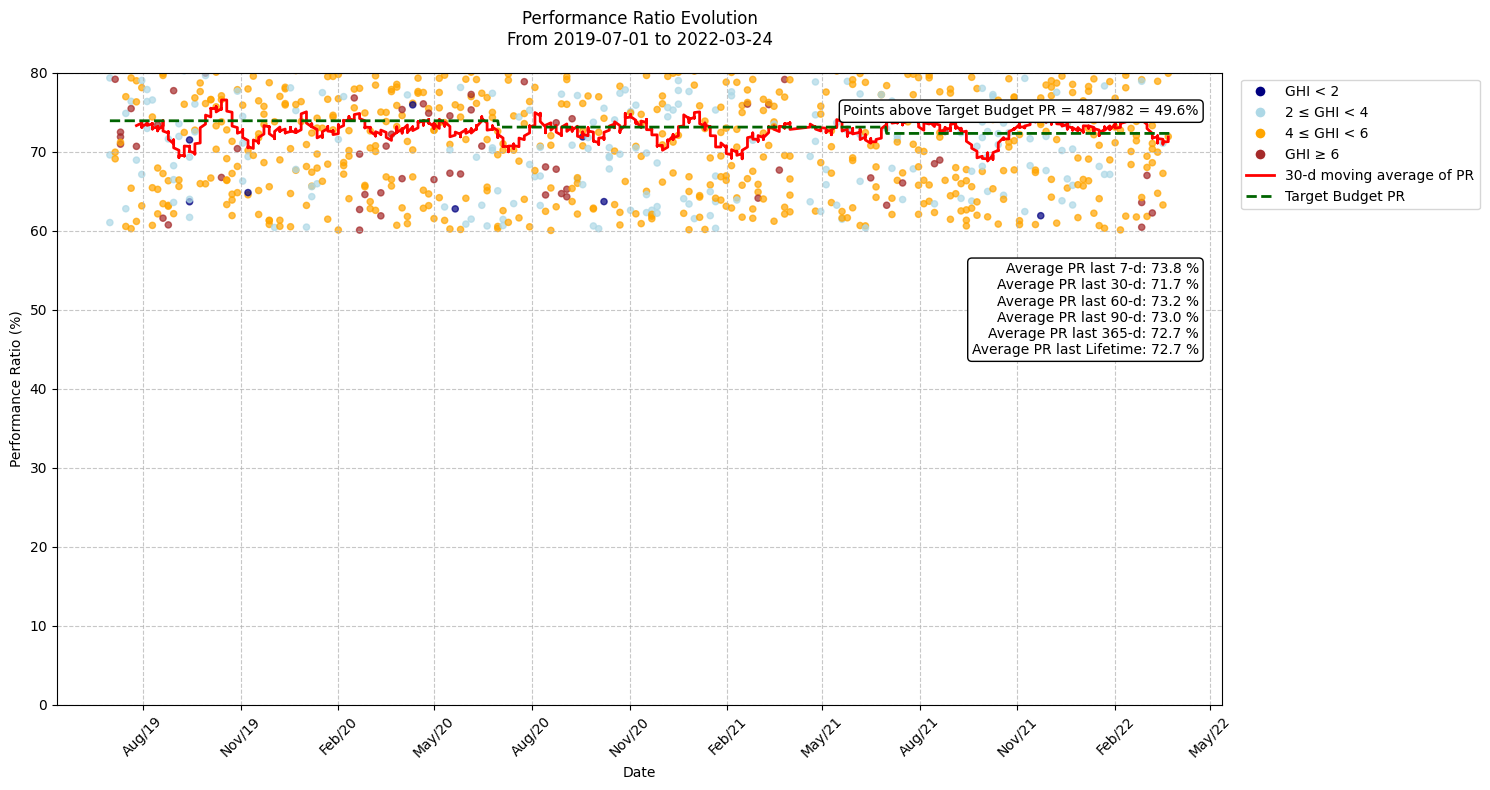

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

def generate_pr_evolution_graph(combined_data, start_date='2019-07-01', end_date='2022-03-24'):
    """
    Generate Performance Ratio Evolution graph from combined dataset containing both PR and GHI.
    
    Parameters:
        combined_data (DataFrame): Contains 'Date', 'PR', and 'GHI' columns
        start_date (str): Start date of analysis
        end_date (str): End date of analysis
    """
    # Prepare the data
    df = combined_data.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].sort_values('Date')
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Calculate 30-day moving average
    df['30d_MA'] = df['PR'].rolling(window=30).mean()
    
    # Calculate budget PR line (starts at 73.9%, decreases by 0.8% each year)
    base_pr = 73.9
    yearly_decrease = 0.8
    
    # Generate budget PR values for each day
    dates = pd.date_range(start_date, end_date)
    budget_pr = []
    for date in dates:
        years_elapsed = (date - pd.to_datetime(start_date)).days / 365.25
        budget_pr.append(base_pr - yearly_decrease * np.floor(years_elapsed))
    budget_df = pd.DataFrame({'Date': dates, 'Budget_PR': budget_pr})
    
    # Assign colors based on GHI values
    def get_ghi_color(ghi):
        if ghi < 2:
            return '#000080'  # Navy blue
        elif 2 <= ghi < 4:
            return '#ADD8E6'  # Light blue
        elif 4 <= ghi < 6:
            return '#FFA500'  # Orange
        else:
            return '#A52A2A'  # Brown
    
    df['color'] = df['GHI'].apply(get_ghi_color)
    
    # Create scatter plot with color-coded points
    ax.scatter(df['Date'], df['PR'], c=df['color'], alpha=0.7, s=20)
    
    # Plot 30-day moving average (red line)
    ax.plot(df['Date'], df['30d_MA'], color='red', linewidth=2, label='30-d moving average of PR')
    
    # Plot budget PR line (dark green)
    ax.plot(budget_df['Date'], budget_df['Budget_PR'], color='darkgreen', linewidth=2, 
            linestyle='--', label='Target Budget PR')
    
    # Calculate points above target budget
    merged = pd.merge(df, budget_df, on='Date')
    points_above_target = len(merged[merged['PR'] > merged['Budget_PR']])
    total_points = len(merged)
    percentage_above = (points_above_target / total_points) * 100
    
    # Add annotations
    ax.annotate(f'Points above Target Budget PR = {points_above_target}/{total_points} = {percentage_above:.1f}%',
                xy=(0.98, 0.95), xycoords='axes fraction',
                ha='right', va='top', bbox=dict(boxstyle='round', fc='white'))
    
    # Calculate various moving averages
    current_date = pd.to_datetime(end_date)
    averages = {
        '7-d': df[df['Date'] > current_date - timedelta(days=7)]['PR'].mean(),
        '30-d': df[df['Date'] > current_date - timedelta(days=30)]['PR'].mean(),
        '60-d': df[df['Date'] > current_date - timedelta(days=60)]['PR'].mean(),
        '90-d': df[df['Date'] > current_date - timedelta(days=90)]['PR'].mean(),
        '365-d': df[df['Date'] > current_date - timedelta(days=365)]['PR'].mean(),
        'Lifetime': df['PR'].mean()
    }
    
    # Add moving averages annotation
    avg_text = '\n'.join([f'Average PR last {k}: {v:.1f} %' for k, v in averages.items()])
    ax.annotate(avg_text, xy=(0.98, 0.7), xycoords='axes fraction',
                ha='right', va='top', bbox=dict(boxstyle='round', fc='white'))
    
    # Format x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))
    plt.xticks(rotation=45)
    
    # Set labels and title
    ax.set_title('Performance Ratio Evolution\nFrom 2019-07-01 to 2022-03-24', pad=20)
    ax.set_ylabel('Performance Ratio (%)')
    ax.set_xlabel('Date')
    ax.set_ylim(0, 80)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Create custom legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='GHI < 2', markerfacecolor='#000080', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='2 ≤ GHI < 4', markerfacecolor='#ADD8E6', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='4 ≤ GHI < 6', markerfacecolor='#FFA500', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='GHI ≥ 6', markerfacecolor='#A52A2A', markersize=8),
        plt.Line2D([0], [0], color='red', lw=2, label='30-d moving average of PR'),
        plt.Line2D([0], [0], color='darkgreen', lw=2, linestyle='--', label='Target Budget PR')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.01, 1))
    
    plt.tight_layout()
    return fig, ax

fig, ax = generate_pr_evolution_graph(df)
plt.savefig('performance_ratio_evolution.png', dpi=300, bbox_inches='tight')
plt.show()